## Victor Manuel Gómez Espinosa
### victor.gomez@cimat.mx


# Dirección de los archivos

In [ ]:
#librerias
import os
CurrentPath = '/content/drive/My Drive/KUESKI_Challenge'

os.chdir(CurrentPath) #cambiar la ubicacion a la carpeta donde se encuentra este archivo
!ls #listar los documentos en esta ruta

1_Basic_exploratory_analysis.ipynb
2_Model_implementation.ipynb
3_Analytics_on_the_model_performance.ipynb
datos_completos.csv
datos.csv
datos.gsheet
EliminandoCasosIncomp_Challenge2.ipynb
listings_reduced_completeFeatures.csv
listings_reduced.csv
_missing_value.py
__pycache__
Resultados


# Librerías

In [ ]:
# librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.model_selection import train_test_split
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
import joblib
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import median_absolute_error

# Análisis descriptivo y exploratorio

# Datos

Leemos los datos y exploramos las variables

In [ ]:
df=pd.read_csv('listings_reduced.csv',index_col=0,na_values=['unk','unknown',' ','  ',None]) #leemos los datos

In [ ]:
df.head(5) #muestra los 5 primeros

,id,name,description,host_id,host_name,host_since,host_about,host_response_time,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,minimum_nights,maximum_nights,availability_90,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month
0,10595,"96m2, 3BR, 2BA, Metro, WI-FI etc...",Athens Furnished Apartment No6 is 3-bedroom ap...,37177,Emmanouil,2009-09-08,Athens Quality Apartments is a company started...,within an hour,t,6.0,t,37.98888,23.76431,Entire home/apt,8,2.0,3.0,5.0,1076.0,$80.00,4,1,45,46,22,2011-05-20,2019-08-07,96.0,10.0,10.0,10.0,10.0,9.0,0.21
1,10990,"50m2, Metro, WI-FI, cableTV, more",Athens Furnished Apartment No3 is 1-bedroom ap...,37177,Emmanouil,2009-09-08,Athens Quality Apartments is a company started...,within an hour,t,6.0,t,37.98783,23.76479,Entire home/apt,4,1.0,1.0,1.0,NaN,$50.00,2,1,60,79,31,2012-09-06,2019-04-21,97.0,10.0,10.0,10.0,10.0,10.0,0.35
2,10993,Athens Quality Apartments - Studio,The Studio is an -excellent located -close t...,37177,Emmanouil,2009-09-08,Athens Quality Apartments is a company started...,within an hour,t,6.0,t,37.98861,23.76422,Entire home/apt,2,1.0,0.0,1.0,NaN,$44.00,2,1,60,75,47,2012-09-24,2019-04-17,97.0,10.0,10.0,10.0,10.0,10.0,0.54
3,10995,"47m2, close to metro,cable TV,wi-fi",AQA No2 is 1-bedroom apartment (47m2) -excell...,37177,Emmanouil,2009-09-08,Athens Quality Apartments is a company started...,within an hour,t,6.0,t,37.98950,23.76356,Entire home/apt,4,1.0,1.0,2.0,NaN,$50.00,2,1,60,85,19,2010-07-08,2019-04-19,96.0,10.0,10.0,10.0,10.0,9.0,0.17
4,27262,"54m2, 1-br, cable tv, wi-fi, metro",Big 1-bedroom apartment that can accommodate 4...,37177,Emmanouil,2009-09-08,Athens Quality Apartments is a company started...,within an hour,t,6.0,t,37.98893,23.76475,Entire home/apt,4,1.0,1.0,1.0,NaN,$50.00,2,1,30,86,16,2012-09-21,2017-05-15,95.0,10.0,10.0,10.0,10.0,9.0,0.18


In [ ]:
df.info()#información general del dataframe, para ver casos incompletos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11263 entries, 0 to 11262
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           11263 non-null  int64  
 1   name                         11255 non-null  object 
 2   description                  11098 non-null  object 
 3   host_id                      11263 non-null  int64  
 4   host_name                    11261 non-null  object 
 5   host_since                   11261 non-null  object 
 6   host_about                   6553 non-null   object 
 7   host_response_time           9562 non-null   object 
 8   host_is_superhost            11261 non-null  object 
 9   host_listings_count          11261 non-null  float64
 10  host_identity_verified       11261 non-null  object 
 11  latitude                     11263 non-null  float64
 12  longitude                    11263 non-null  float64
 13  room_type       

In [ ]:
#cambiamos a variables booleanas
df.host_is_superhost[df.host_is_superhost=='t']=True
df.host_is_superhost[df.host_is_superhost=='f']=False

df.host_identity_verified[df.host_identity_verified=='t']=True
df.host_identity_verified[df.host_identity_verified=='f']=False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying t

In [ ]:
#variable respuesta en formato texto, cambiamos a tipo flotante
price=df.price.values #variable respuesta
prices=[]

for p in price:
  p=p[1:]
  p=p.replace(",","") #quita comas
  p=float(p)
  prices.append(p)

prices=np.array(prices)

Nos quedamos con variables numéricas y categóricas, respecto a:
-	Host
-	Ubicación
-	Tipo de habitación
-	Características de la habitación
-	Puntuaciones de la habitación en diferentes categorías


In [ ]:
#quitamos variables que contienen muy poca informacion (square_feet <1%) o que en este caso (por el momento) consideramos no nos sirven (fechas)
id=df.id.values #etiquetas
y=prices

df=df.drop(columns=['id','price','name','description','host_id','host_name','host_since','host_about','square_feet','first_review',	'last_review', 'maximum_nights']) 


Observación:

- Las categorías del tipo de habitación están desbalanceadas, esto podría indicar un problema de regresión no balanceado.

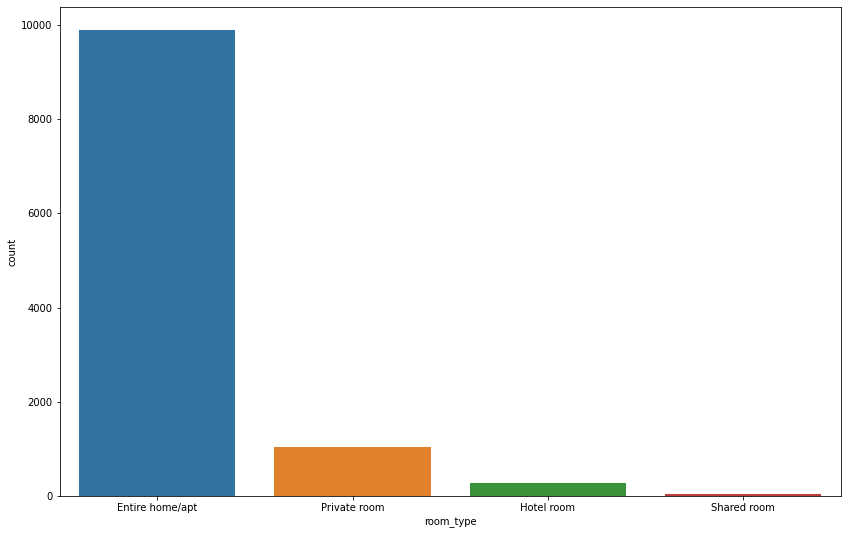

In [ ]:
f, ax = plt.subplots(figsize=(14,9)) #subplots and zise
sns.countplot(x="room_type", data=df)

In [ ]:
df.room_type.value_counts()/len(df)

Entire home/apt    0.876676
Private room       0.092338
Hotel room         0.025837
Shared room        0.005150
Name: room_type, dtype: float64

Obtenemos variables dummies de las variables categóricas (eliminamos la primera si es binaria)

In [ ]:
df=pd.get_dummies(df, drop_first=False) #obtenemos variables dummies quitando la primera si es binaria
df=df.drop(columns=['host_identity_verified_False','host_is_superhost_False'])
df['price']=y
df.index=id
df.info()#información general del dataframe, para ver casos incompletos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11263 entries, 10595 to 40200475
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_listings_count                    11261 non-null  float64
 1   latitude                               11263 non-null  float64
 2   longitude                              11263 non-null  float64
 3   accommodates                           11263 non-null  int64  
 4   bathrooms                              11263 non-null  float64
 5   bedrooms                               11258 non-null  float64
 6   beds                                   11254 non-null  float64
 7   guests_included                        11263 non-null  int64  
 8   minimum_nights                         11263 non-null  int64  
 9   availability_90                        11263 non-null  int64  
 10  number_of_reviews                      11263 non-null  int64  


Algunas variables tienen datos faltantes

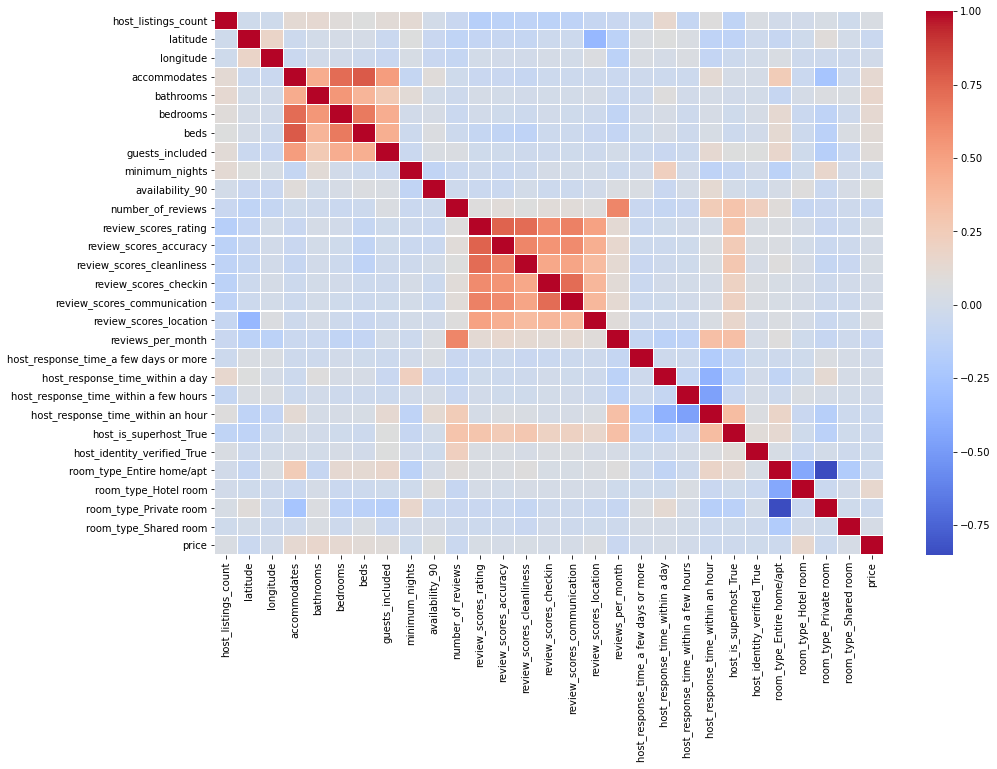

In [ ]:
f, ax = plt.subplots(figsize=(15,10)) #subplots and zise
sns.heatmap(round(df.corr(),2), annot=False, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)

Observaciones:
-	Algunas de las variables están fuertemente correlacionadas positiva o negativamente



In [ ]:
df.describe()

,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_True,host_identity_verified_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price
count,11261.000000,11263.000000,11263.000000,11263.000000,11263.000000,11258.000000,11254.000000,11263.000000,11263.000000,11263.000000,11263.000000,8924.000000,8921.000000,8921.000000,8919.000000,8920.000000,8919.000000,8990.00000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000
mean,16.648610,37.980246,23.731795,3.990589,1.208914,1.416681,2.192021,1.913433,3.555713,60.271508,35.719613,95.091999,9.744984,9.643874,9.829577,9.825561,9.534141,2.30386,0.016958,0.057800,0.087366,0.686851,0.377342,0.211933,0.876676,0.025837,0.092338,0.005150,65.955784
std,47.577101,0.013547,0.012610,2.168391,0.494457,0.871730,1.601287,1.202045,19.754569,31.610708,59.651985,7.438729,0.720055,0.772973,0.601165,0.631832,0.794080,2.19813,0.129120,0.233375,0.282383,0.463795,0.484743,0.408696,0.328824,0.158655,0.289515,0.071579,157.752331
min,0.000000,37.949950,23.696750,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.01000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,37.969175,23.723910,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45.000000,1.000000,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,0.57000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,33.500000
50%,2.000000,37.978600,23.729900,4.000000,1.000000,1.000000,2.000000,2.000000,2.000000,73.000000,11.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.58500,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,48.000000
75%,9.000000,37.988850,23.738760,5.000000,1.000000,2.000000,3.000000,2.000000,2.000000,86.000000,44.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.48000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,70.000000
max,1111.000000,38.035050,23.786020,26.000000,10.000000,14.000000,23.000000,16.000000,1000.000000,90.000000,694.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,16.27000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7000.000000


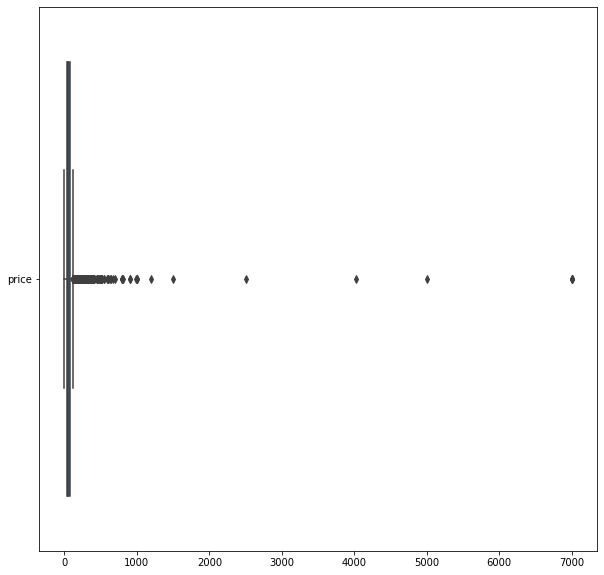

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=df[['price']],orient="h") #boxplot horizontal

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



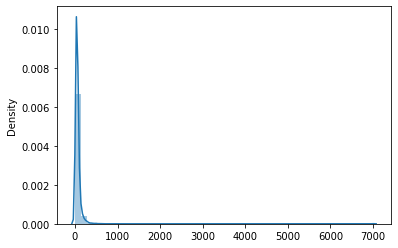

In [ ]:
sns.distplot(df[['price']])
plt.show()

Observaciones:
-	Para la variable respuesta se tiene una distribución sesgada a la derecha, 
-	En el histograma se notan valores atípicos, uno de ellos es un 0, (posible error), los demás no se sabe y hay que consultar con el experto si realmente son outliers
-	En estos casos lo mejor es utilizar una función de costo basada en la mediana ya que es más representativo que el promedio (valores atípicos la jalan)


In [ ]:
df.price[df.price==0]=np.nan #el outlier con 0 lo cambiamos por nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:

df.to_csv('datos.csv') #guardamos los datos que vamos a utilizar